# Diabetic Retinopathy Detection Using Fundus Images


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Q-net

In [ ]:
!pip install torch torchvision
!pip install torch torchvision pennylane pennylane-lightning

In [ ]:
import os
import cv2
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define your path to the dataset in Google Drive
image_dir = '/content/drive/MyDrive/DR-images'

# Define custom dataset
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        # Load the image using OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (PIL uses RGB)

        if self.transform:
            image = Image.fromarray(image)  # Convert to PIL image for torchvision transforms
            image = self.transform(image)

        # Example: Assign labels based on file name (if DR and non-DR images are named accordingly)
        # In practice, you may need to adjust this
        label = 1 if 'DR' in self.image_names[idx] else 0

        return image, label

# Preprocessing transformations (resize images and normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64
    transforms.ToTensor(),        # Convert the image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the tensor
])

# Initialize the dataset
dataset = DiabeticRetinopathyDataset(image_dir=image_dir, transform=transform)

# Initialize DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check sample output- This represents a batch of 32 images, where each image has 3 channels (RGB) and a resolution of 64x64 pixels.
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from pennylane import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim

# Define the quantum device (e.g., 4 qubits with lightning backend)
n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define a simple quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs):
    # Encoding classical inputs into quantum states
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Apply some quantum gates (entanglement and rotations)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    for i in range(n_qubits):
        qml.RX(0.3, wires=i)

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Quantum layer in PyTorch
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()

    def forward(self, x):
        # Feed each batch into the quantum circuit
        q_out = torch.zeros((x.size(0), n_qubits))  # Batch of size 32, 4 qubit outputs
        for i in range(x.size(0)):
            # Convert the output of the quantum circuit to a torch tensor
            q_out[i] = torch.tensor(quantum_circuit(x[i]), dtype=torch.float32)
        return q_out

# Hybrid CNN-Quantum model
class HybridCNN(nn.Module):
    def __init__(self):
        super(HybridCNN, self).__init__()

        # Classical CNN layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 4)  # 4 inputs for quantum layer

        # Quantum Layer
        self.q_layer = QuantumLayer()

        # Final fully connected layer
        self.fc2 = nn.Linear(n_qubits, 2)  # Binary classification (DR or No-DR)

    def forward(self, x):
        # Classical CNN part
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))

        # Quantum layer part
        x = self.q_layer(x)

        # Fully connected output
        x = self.fc2(x)
        return x

# Initialize the model, loss, and optimizer
model = HybridCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Sample data loader for training
# Assume `train_loader` is defined from earlier code
for epoch in range(2):  # Run 2 epochs as an example
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.266104308622224
Epoch 2, Loss: 0.23669240730149405


**U-Net is a type of convolutional neural network designed primarily for image segmentation tasks, where the goal is to classify each pixel of an image into a specific class. This is a supervised learning task, which means the model learns from labeled data. The masked images serve as the labels.**


**During training, the U-Net model takes an input image and tries to predict a segmentation mask. The ground truth masks (stored in the masked images directory) are used to compare the predicted masks with the actual masks. This comparison is typically done using a loss function, such as cross-entropy loss or dice coefficient loss, which quantifies the difference between the predicted mask and the ground truth mask.**

The loss calculated from the difference between the predicted and ground truth masks is used to optimize the model's parameters. The process of backpropagation updates the model weights to minimize this loss, improving the accuracy of the segmentation over time.



In [ ]:
#In a U-Net model, a masked images directory is created to store the ground truth masks corresponding to the input images.
#Creating a new folder for masked image directory
import os

# Define the new directory path
new_dir = '/content/drive/MyDrive/DR-models-and-masks'

# Create the new directory
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

print(f"Directory {new_dir} created successfully.")

Directory /content/drive/MyDrive/DR-models-and-masks_test created successfully.


In [ ]:
#Loading and preprocessing the original images to create masked grayscale images for ground truth based on the threshold value.

import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to load images from a folder
def load_images_from_folder(folder, color_mode='rgb'):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), color_mode=color_mode)
        if img is not None:
            images.append(img_to_array(img))
    return images

# Preprocess images
def preprocess_image(image, target_size=(256, 256)):
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

# Directory paths
image_dir = '/content/drive/MyDrive/DR-images'  # Directory containing the input images
output_mask_dir = '/content/drive/MyDrive/DR-models-and-masks'  # Directory to save the generated masks

# Create output directory if it doesn't exist
if not os.path.exists(output_mask_dir):
    os.makedirs(output_mask_dir)

# Load and preprocess images
images = load_images_from_folder(image_dir, color_mode='rgb')
preprocessed_images = [preprocess_image(img) for img in images]

# Convert to numpy array
X = np.array(preprocessed_images)
print(f'Image shape: {X.shape}')
# Function to create masks by thresholding
def create_mask(image, threshold=0.5):
    # Convert image to grayscale
    gray_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    # Normalize to [0, 1]
    gray_image = gray_image / 255.0
    # Apply threshold
    mask = (gray_image > threshold).astype(np.float32)
    return mask

# Create and save masks
for i, image in enumerate(X):
    # Create mask
    mask = create_mask(image)

    # Original image path
    original_image_path = os.path.join(image_dir, os.listdir(image_dir)[i])
    original_image = load_img(original_image_path)
    original_size = (original_image.width, original_image.height)

    # Resize mask to original size
    mask = cv2.resize(mask, original_size)
    mask = (mask * 255).astype(np.uint8)  # Convert back to uint8

    # Save mask
    output_path = os.path.join(output_mask_dir, f'mask_{i}.png')
    cv2.imwrite(output_path, mask)

print("Masked grayscale images saved successfully.")

Image shape: (397, 256, 256, 3)
Masked grayscale images saved successfully.


In [ ]:
#Training the U-net Segmentation model
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Function to load images from a folder
def load_images_from_folder(folder, color_mode='rgb'):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), color_mode=color_mode)
        if img is not None:
            images.append(img_to_array(img))
    return images

# Preprocess images and masks
def preprocess_image(image, target_size=(256, 256)):
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

# Directory paths
image_dir = '/content/drive/MyDrive/DR-images'  # Directory containing the input images
mask_dir = '/content/drive/MyDrive/DR-models-and-masks'  # Directory containing the mask images

# Load and preprocess images
images = load_images_from_folder(image_dir, color_mode='rgb')
preprocessed_images = [preprocess_image(img) for img in images]

# Load and preprocess masks
masks = load_images_from_folder(mask_dir, color_mode='grayscale')
preprocessed_masks = [preprocess_image(mask) for mask in masks]

# Convert to numpy array
X = np.array(preprocessed_images)
Y = np.array(preprocessed_masks)

# Ensure masks are binary (0 or 1)
Y = (Y > 0).astype(np.float32)

# Add an extra dimension to masks
Y = np.expand_dims(Y, axis=-1)

print(f'Image shape: {X.shape}')
print(f'Mask shape: {Y.shape}')

Image shape: (397, 256, 256, 3)
Mask shape: (397, 256, 256, 1)


In [ ]:
# Define the U-Net model
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D((2, 2))(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(m1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(m2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# Training the U-net Model for Diabetes Retinopathy Detection.
# Train the model
history = model.fit(X, Y, batch_size=8, epochs=50, validation_split=0.1)

# Save the model
model.save('/content/drive/MyDrive/DR-models/unet_model.h5')

Epoch 1/50
45/45 [==============================] - 14s 313ms/step - loss: 0.0270 - accuracy: 0.9884 - val_loss: 0.0350 - val_accuracy: 0.9851
Epoch 2/50
45/45 [==============================] - 14s 312ms/step - loss: 0.0280 - accuracy: 0.9881 - val_loss: 0.0189 - val_accuracy: 0.9915
Epoch 3/50
45/45 [==============================] - 14s 303ms/step - loss: 0.0330 - accuracy: 0.9859 - val_loss: 0.0143 - val_accuracy: 0.9943
Epoch 4/50
45/45 [==============================] - 13s 299ms/step - loss: 0.0327 - accuracy: 0.9863 - val_loss: 0.0163 - val_accuracy: 0.9936
Epoch 5/50
45/45 [==============================] - 13s 296ms/step - loss: 0.0304 - accuracy: 0.9869 - val_loss: 0.0166 - val_accuracy: 0.9938
Epoch 6/50
45/45 [==============================] - 13s 291ms/step - loss: 0.0266 - accuracy: 0.9886 - val_loss: 0.0177 - val_accuracy: 0.9921
Epoch 7/50
45/45 [==============================] - 13s 296ms/step - loss: 0.0275 - accuracy: 0.9882 - val_loss: 0.0148 - val_accuracy: 0.9944

In [ ]:
#Evaluate the model on the training data
loss, accuracy = model.evaluate(X, Y)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 22s 797ms/step - loss: 0.0679 - accuracy: 0.9694
Loss: 0.06790810823440552
Accuracy: 0.9693900942802429


In [ ]:
# Data Normalization: Normalize images to range [0, 1]
def preprocess_image(image, target_size=(256, 256)):
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

# Ensure masks are binary (0 or 1)
def preprocess_mask(mask, target_size=(256, 256)):
    mask = cv2.resize(mask, target_size)
    mask = (mask > 0).astype(np.float32)
    return mask

# Load and preprocess images
images = load_images_from_folder(image_dir, color_mode='rgb')
preprocessed_images = [preprocess_image(img) for img in images]

# Load and preprocess masks
masks = load_images_from_folder(mask_dir, color_mode='grayscale')
preprocessed_masks = [preprocess_mask(mask) for mask in masks]

# Convert to numpy array
X = np.array(preprocessed_images)
Y = np.array(preprocessed_masks)

# Add an extra dimension to masks
Y = np.expand_dims(Y, axis=-1)

print(f'Image shape: {X.shape}')
print(f'Mask shape: {Y.shape}')

Image shape: (397, 256, 256, 3)
Mask shape: (397, 256, 256, 1)


In [ ]:
#Redefine and Train the Model
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D((2, 2))(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(m1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(m2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X, Y, batch_size=8, epochs=10, validation_split=0.1)

# Save the model
model.save('/content/drive/MyDrive/DR-models/unet_model.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_12[0][0]']           
 g2D)                                                                                       

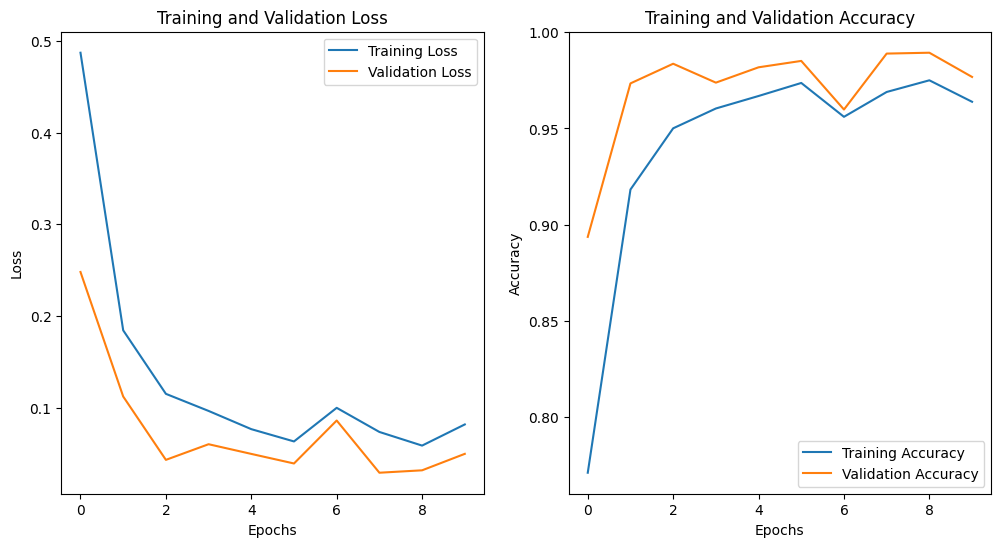

In [ ]:
# Plot detailed training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
#Evaluate the model on the training data
# Evaluate the model
loss, accuracy = model.evaluate(X, Y)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 4s 321ms/step - loss: 0.0679 - accuracy: 0.9694
Loss: 0.06790810823440552
Accuracy: 0.9693900942802429


In [ ]:
# Load new test images
test_image_dir = '/content/drive/MyDrive/DR-models-and-masks_test'  # Directory containing the test images

# Load and preprocess images
test_images = load_images_from_folder(test_image_dir, color_mode='rgb')
preprocessed_test_images = [preprocess_image(img) for img in test_images]

# Convert to numpy array
X_test = np.array(preprocessed_test_images)

2/2 [==============================] - 0s 359ms/step


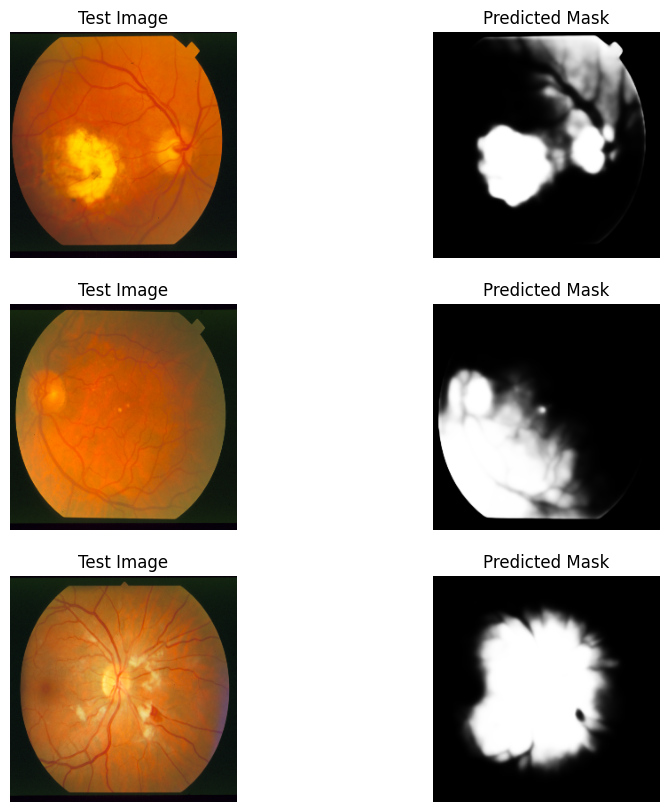

In [ ]:
# Predict masks for test images
predicted_test_masks = model.predict(X_test)

#Visualizations of Predictions

def visualize_predictions(test_images, predicted_masks, num_samples=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(array_to_img(test_images[i]))
        plt.title("Test Image")
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.show()

visualize_predictions(preprocessed_test_images, predicted_test_masks)

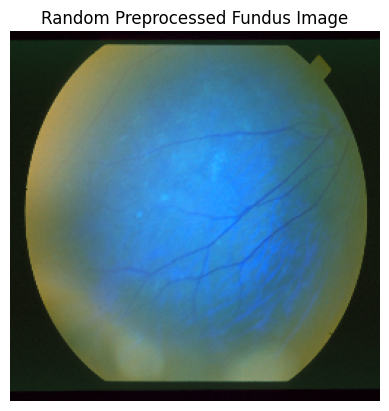

In [ ]:
# Visualizing a Random Image
import matplotlib.pyplot as plt

# Select a random image
random_index = random.randint(0, len(preprocessed_images) - 1)
random_image = preprocessed_images[random_index]

# Visualize the random image
plt.imshow(random_image)
plt.title("Random Preprocessed Fundus Image")
plt.axis('off')
plt.show()

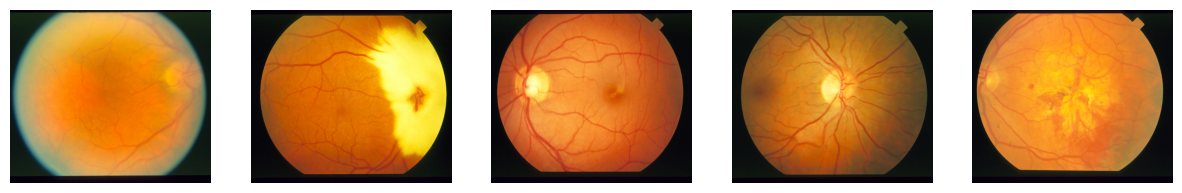

In [ ]:
# Function to display multiple random images
def display_random_images(images, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        random_image = images[random.randint(0, len(images) - 1)]
        plt.imshow(random_image)
        plt.axis('off')
    plt.show()

# Function to display histograms of pixel intensities
def display_histograms(images, n=3):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        random_image = images[random.randint(0, len(images) - 1)]
        plt.hist(random_image.ravel(), bins=256, color='orange', )
        plt.hist(random_image[:, :, 0].ravel(), bins=256, color='r', alpha=0.5)
        plt.hist(random_image[:, :, 1].ravel(), bins=256, color='g', alpha=0.5)
        plt.hist(random_image[:, :, 2].ravel(), bins=256, color='b', alpha=0.5)
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
    plt.show()

# Function to display color channels separately
def display_color_channels(images, n=3):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        random_image = images[random.randint(0, len(images) - 1)]
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(random_image[:, :, 0], cmap='Reds')
        plt.axis('off')
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(random_image[:, :, 1], cmap='Greens')
        plt.axis('off')
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(random_image[:, :, 2], cmap='Blues')
        plt.axis('off')
    plt.show()

# Function to apply and display edge detection
def display_edge_detection(images, n=3):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        random_image = images[random.randint(0, len(images) - 1)]
        gray = cv2.cvtColor(random_image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
    plt.show()

# Function to highlight blood vessels using color thresholding
def highlight_blood_vessels(images, n=3):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        random_image = images[random.randint(0, len(images) - 1)]
        green_channel = random_image[:, :, 1]
        _, binary = cv2.threshold(green_channel, 30, 255, cv2.THRESH_BINARY)
        plt.imshow(binary, cmap='gray')
        plt.axis('off')
    plt.show()

# Set the path to the directory containing the fundus images
image_dir = '/content/drive/MyDrive/DR-images'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

# Load images
images = load_images_from_folder(image_dir)

# Display multiple random images
#Multiple Random Images: Displaying a set of random images from our dataset.
display_random_images(images)

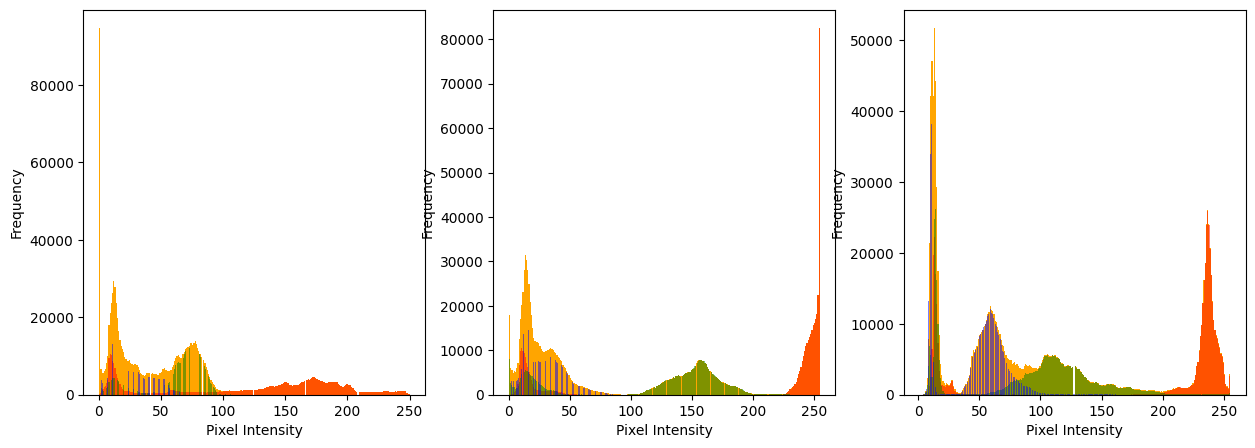

In [ ]:
# Display histograms of pixel intensities
#Histograms of Pixel Intensities: Showing the distribution of pixel intensities for random images, including separate histograms for each color channel.
display_histograms(images)

Identifying Retinal Abnormalities


**Red** Channel: Often, the red channel can help highlight hemorrhages and microaneurysms, which appear as small red dots or blotches in the retina. These features are critical indicators of DR. In the red channel, hemorrhages and microaneurysms are often more visible as they contrast well with the surrounding retinal tissue.

**Green** Channel: The green channel is particularly useful for identifying blood vessels and other structures within the retina because it provides good contrast. Blood vessels and hemorrhages are more easily visible. In the green channel, blood vessels stand out more distinctly. This is particularly useful for segmenting and analyzing the vascular structure of the retina, which can be affected by DR.

**Blue** Channel: The blue channel, while less commonly used alone, can sometimes help in identifying hard exudates and cotton wool spots due to its sensitivity to high-frequency details. In the blue channel, some features like hard exudates and cotton wool spots may become more apparent due to the high-frequency details captured in this channel.

**By examining the individual color channels,** certain features of the retina that are crucial for diagnosing DR can be enhanced or made more prominent, facilitating easier detection by algorithms and human experts.

**Color channel separation is often used as a preprocessing step** in various image processing and segmentation techniques. By working with individual channels, algorithms can focus on specific features relevant to DR detection.

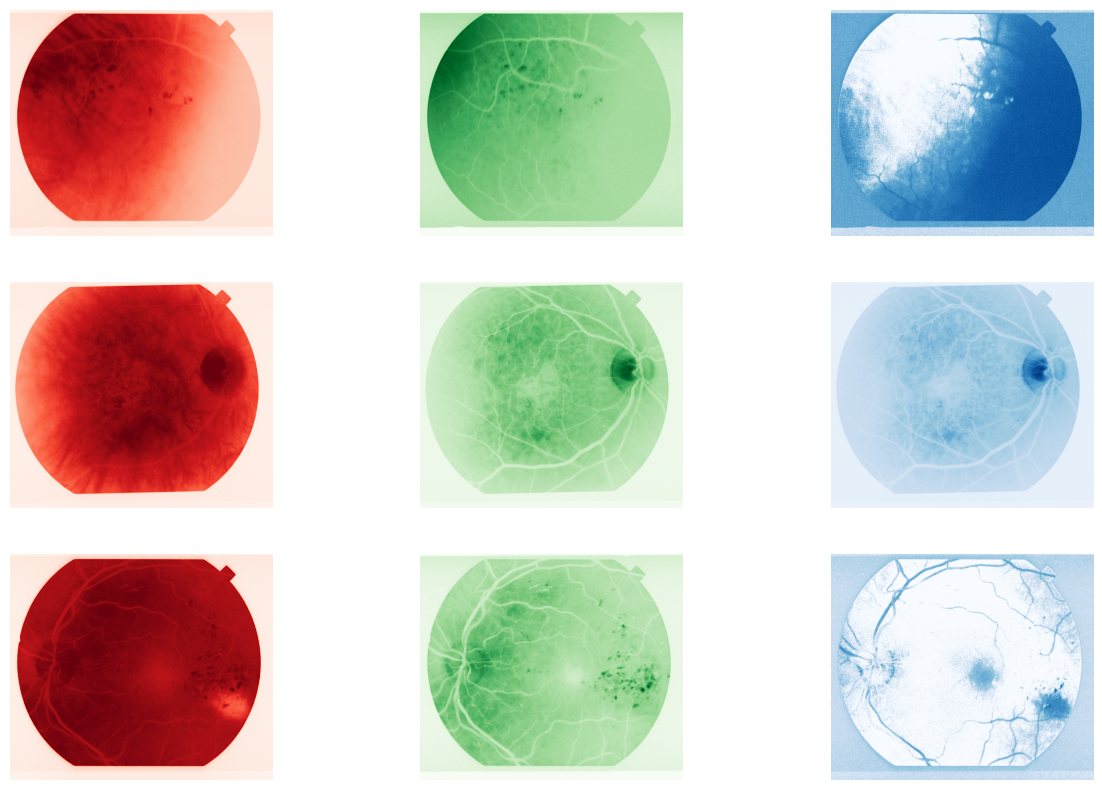

In [ ]:
#Displaying color channels separately
#Color Channels: Display the red, green, and blue channels of random images separately.
display_color_channels(images)

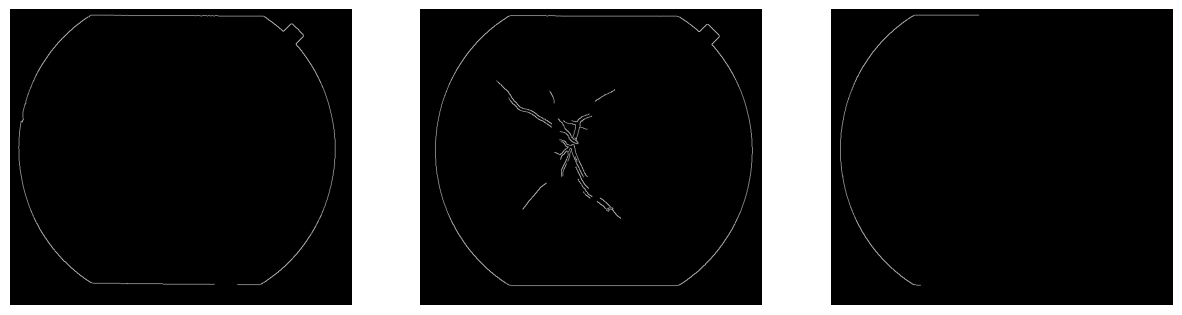

In [ ]:
# Apply and display edge detection
#Edge detection helps in highlighting the boundaries and shapes of various structures within the retina, which can be crucial for identifying abnormalities
#associated with DR.
#Edge detection can enhance the outlines of blood vessels, making it easier to segment and analyze the vascular network.
display_edge_detection(images)

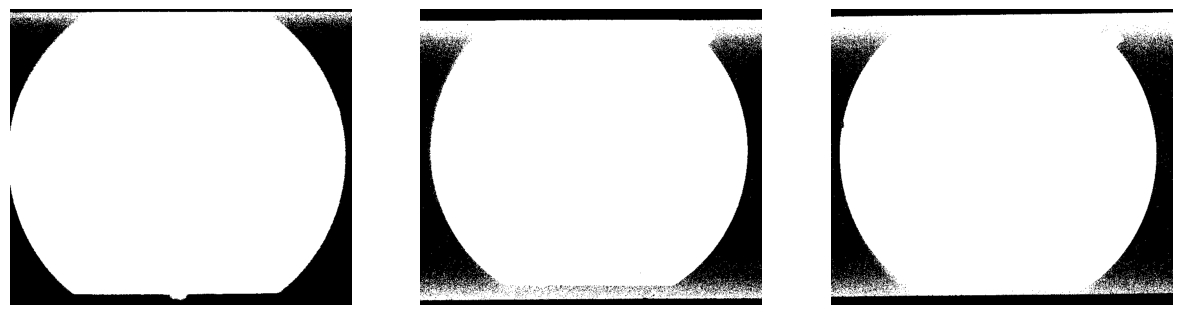

In [ ]:
# Highlighting blood vessels using color thresholding can be an effective method for detecting and analyzing the vascular structure in fundus images,
#which is crucial for diagnosing Diabetic Retinopathy (DR).
#Blood vessels are prominent indicators of various stages of DR. Highlighting them using color thresholding makes it easier to segment
#and analyze the vascular network.
#One of the advanced signs of DR is neovascularization, the formation of new, abnormal blood vessels.
#Highlighting existing vessels can help in detecting these new formations by comparing them against the normal vascular pattern.

highlight_blood_vessels(images)

**Generative Adversarial Networks (GANs)**

Number of images found: 417


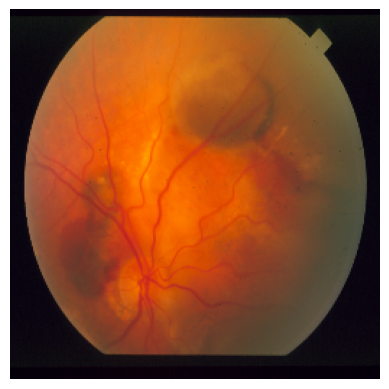

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths
data_path = '/content/drive/MyDrive/DR-images/'

# Check for .ppm files
image_files = glob(data_path + '*.ppm')

# Print the number of images found
print(f"Number of images found: {len(image_files)}")
if len(image_files) == 0:
    print("No images found. Please check the path and file extension.")
else:
    # Function to preprocess images
    def preprocess_image(image_path, img_size=(256, 256)):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to [0, 1]
        return img

    # Load and preprocess all images
    preprocessed_images = [preprocess_image(img_path) for img_path in image_files]
    preprocessed_images = np.array(preprocessed_images)

    # Display a random preprocessed image
    def display_random_image(images):
        idx = np.random.randint(len(images))
        plt.imshow(images[idx])
        plt.axis('off')
        plt.show()

    display_random_image(preprocessed_images)

In [ ]:
# Assuming preprocessed_images is a numpy array of shape (num_images, 256, 256, 3)
preprocessed_images = (preprocessed_images / 127.5) - 1  # Scale images to [-1, 1]

In [ ]:
#Importing Libraries for GAN model
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, LeakyReLU, Dropout, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ensure compatibility with TensorFlow
tf.compat.v1.disable_eager_execution()

In [ ]:
#Define the Generator model
def build_generator(img_shape, noise_dim):
    model = Sequential()
    model.add(Dense(256 * 64 * 64, activation="relu", input_dim=noise_dim))
    model.add(Reshape((64, 64, 256)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(img_shape[-1], kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(noise_dim,))
    img = model(noise)
    return Model(noise, img)

In [ ]:
#Define the Discriminator model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

In [ ]:
def build_gan(generator, discriminator, noise_dim):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    z = Input(shape=(noise_dim,))
    img = generator(z)

    discriminator.trainable = False
    validity = discriminator(img)

    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return combined

In [ ]:
# Assuming preprocessed_images is a numpy array of shape (num_images, H, W, 3)
# Resize images to the target shape (256, 256, 3)
preprocessed_images_resized = tf.image.resize(preprocessed_images, [256, 256])

# Normalize images to [-1, 1]
preprocessed_images_resized = (preprocessed_images_resized / 127.5) - 1

# Check the shape to ensure it matches
print(preprocessed_images_resized.shape)

(417, 256, 256, 3)


In [ ]:
def train_gan(generator, discriminator, gan, preprocessed_images, noise_dim, epochs, batch_size, sample_interval):
    X_train = preprocessed_images

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    @tf.function
    def train_step(imgs):
        noise = tf.random.normal([batch_size, noise_dim])
        gen_imgs = generator(noise, training=True)

        with tf.GradientTape() as disc_tape:
            real_output = discriminator(imgs, training=True)
            fake_output = discriminator(gen_imgs, training=True)
            d_loss_real = tf.keras.losses.binary_crossentropy(valid, real_output)
            d_loss_fake = tf.keras.losses.binary_crossentropy(fake, fake_output)
            d_loss = d_loss_real + d_loss_fake

        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as gen_tape:
            generated_images = generator(noise, training=True)
            validity = discriminator(generated_images, training=True)
            g_loss = tf.keras.losses.binary_crossentropy(valid, validity)

        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        return d_loss, g_loss

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        d_loss, g_loss = train_step(imgs)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {np.mean(d_loss)}] [G loss: {np.mean(g_loss)}]")
            sample_images(generator, epoch, noise_dim)

def sample_images(generator, epoch, noise_dim, image_grid_rows=4, image_grid_columns=4):
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 10))
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    fig.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

In [ ]:
import matplotlib.pyplot as plt

def train_gan(generator, discriminator, gan, preprocessed_images, noise_dim, epochs, batch_size, sample_interval):
    X_train = preprocessed_images

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    @tf.function
    def train_step(imgs):
        noise = tf.random.normal([batch_size, noise_dim])
        gen_imgs = generator(noise, training=True)

        with tf.GradientTape() as disc_tape:
            real_output = discriminator(imgs, training=True)
            fake_output = discriminator(gen_imgs, training=True)
            d_loss_real = tf.keras.losses.binary_crossentropy(valid, real_output)
            d_loss_fake = tf.keras.losses.binary_crossentropy(fake, fake_output)
            d_loss = d_loss_real + d_loss_fake

        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as gen_tape:
            generated_images = generator(noise, training=True)
            validity = discriminator(generated_images, training=True)
            g_loss = tf.keras.losses.binary_crossentropy(valid, validity)

        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        return d_loss, g_loss

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        d_loss, g_loss = train_step(imgs)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {np.mean(d_loss)}] [G loss: {np.mean(g_loss)}]")
            sample_images(generator, epoch, noise_dim)

def sample_images(generator, epoch, noise_dim, image_grid_rows=4, image_grid_columns=4):
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 10))
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    fig.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

1/1 [==============================] - 18s 18s/step


0 [D loss: 0.6993719637393951 | D accuracy: 23.4375] [G loss: 0.40498247742652893]
1/1 [==============================] - 8s 8s/step


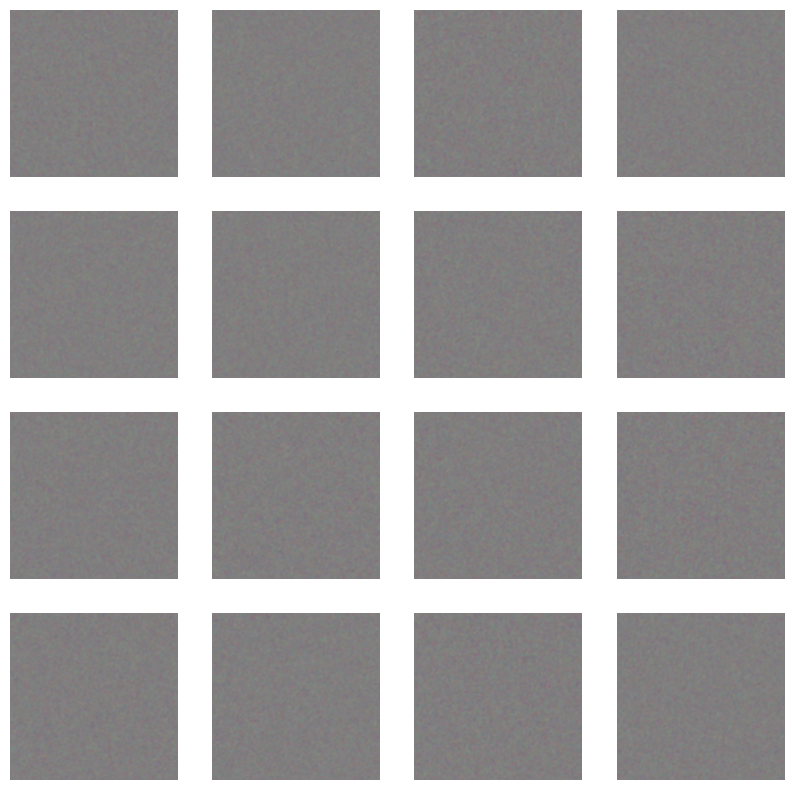

1/1 [==============================] - 12s 12s/step


In [ ]:
# Define the Generator Network
def build_generator(img_shape, noise_dim):
    model = tf.keras.Sequential()

    model.add(Dense(128 * 64 * 64, activation="relu", input_dim=noise_dim))
    model.add(Reshape((64, 64, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(tf.keras.layers.Activation("tanh"))

    noise = Input(shape=(noise_dim,))
    img = model(noise)

    return Model(noise, img)

# Define the Discriminator Network
def build_discriminator(img_shape):
    model = tf.keras.Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Define and Compile the GAN Model
def build_gan(generator, discriminator, noise_dim):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    z = Input(shape=(noise_dim,))
    img = generator(z)

    discriminator.trainable = False

    validity = discriminator(img)

    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return combined

# Training and Sampling Functions
def train_gan(generator, discriminator, gan, preprocessed_images, noise_dim, epochs, batch_size, sample_interval):
    X_train = preprocessed_images

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, valid)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
            sample_images(generator, epoch, noise_dim)

def sample_images(generator, epoch, noise_dim, image_grid_rows=4, image_grid_columns=4):
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 10))
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    fig.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

# Parameters
img_shape = (256, 256, 3)  # Shape of the input images
noise_dim = 100  # Dimension of the noise vector

# Build and compile the GAN
generator = build_generator(img_shape, noise_dim)
discriminator = build_discriminator(img_shape)
gan = build_gan(generator, discriminator, noise_dim)

# Training parameters
epochs = 10000  # Number of training epochs
batch_size = 32  # Size of each batch
sample_interval = 1000  # Interval to save generated images

# Preprocessed images should be provided as 'preprocessed_images' variable
train_gan(generator, discriminator, gan, preprocessed_images, noise_dim, epochs, batch_size, sample_interval)

# Building a Classification Model whether a patient has diabetic Retinopathy or not based on Fundus Images

Loading Images and converting them to grey-Scale followed by adaptive histogram equilisation to the final image matrix is stored in 1-D format in a new 2-D array

In [ ]:
#img_rows=img_cols=200
immatrix=[]
im_unpre = []


for i in range(1,90):
    img_pt = r'/Users/adi/Downloads/DR-images/im0017.ppm'
    if i < 10:
        img_pt = img_pt + "00" + str(i) + ".png"
    else:
        img_pt = img_pt + "0" + str(i)+ ".png"

    img = cv2.imread(img_pt)
    #im_unpre.append(np.array(img).flatten())
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(img_gray)
    immatrix.append(np.array(equ).flatten())
    #res = np.hstack((img_gray,equ))

In [ ]:
np.shape(np.array(equ).flatten())

(1728000,)

Visualising a random image after the above steps the array contains 90 images

---



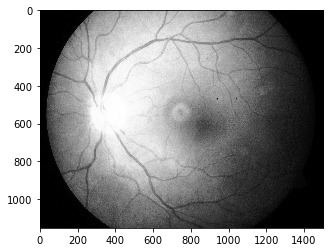

In [ ]:
#Visualising a random image after the above steps the array contains 90 images


#The shape of the image is determined from np.shape(equ) and those values are 1152,1500
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[78].reshape((1152,1500)),cmap='gray')
plt.show()

Performing Discrete-Wavelet transform on the 2-D array available

In [ ]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((1152,1500))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())


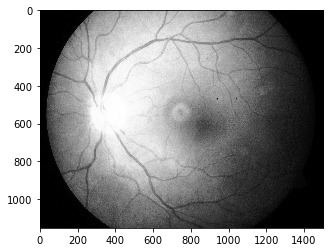

In [ ]:
# Visualising* a random image
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[78].reshape((1152,1500)),cmap='gray')
plt.show()

In [ ]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')

    ctr_x = dim_x / 2
    ctr_y = int(dim_y / 2.)

    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    return cv2.flip(kernel, -1)

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Making subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss.append(np.array(equ3).flatten())


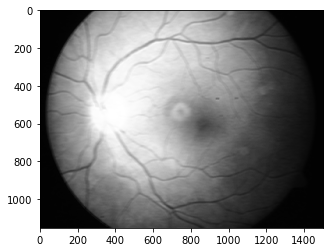

In [ ]:
# The array ranges from 0 - 89
np.shape(imm_gauss)
plt.imshow(imm_gauss[78].reshape((1152,1500)),cmap='gray')
plt.show()

In [ ]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


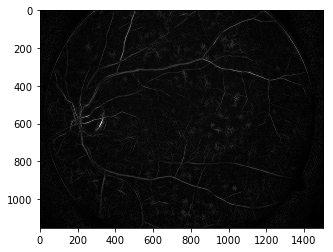

In [ ]:
# The array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[20].reshape((1152,1500)),cmap='gray')
plt.show()

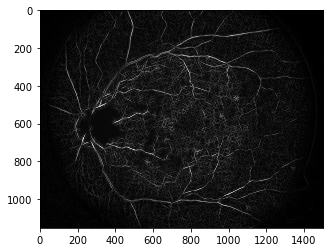

In [ ]:
# The array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((1152,1500)),cmap='gray')
plt.show()

In [ ]:
e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,3))
np.shape(e_)

(576000, 3)

In [ ]:
# Performing K-means Clusttering with PP centers(non random) neighbours on the final image
img = equ3
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# Defining criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [ ]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((1152,1500))
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())



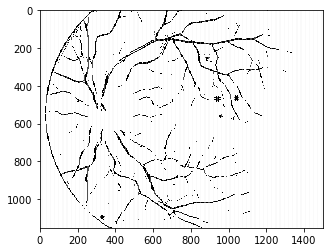

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_kmean)
plt.imshow(imm_kmean[78].reshape((1152,1500)),cmap="gray")
plt.show()

Importing SVc(same as SVM) from sklearn library

In [ ]:
# Model training
from sklearn.svm import SVC
clf = SVC()

In [ ]:
Y = np.ones(89)

These corresponding Images are marked as non-effected in the data-set

In [ ]:
Y[1]=Y[5]=Y[7]=Y[17]=Y[6]=0

SVM with Radial Basis Function (RBF)

Linear SVM classifies the data by putting a hyper plane between the two classes. In the case of rbf SVM the plane would be in infinite dimension

In [ ]:
clf.fit(imm_kmean, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
y_pred = clf.predict(imm_kmean)

In [ ]:
k = [1,3,4,9,10,11,13,14,20,22,24,25,26,27,28,29,35,36,38,42,53,55,57,64,70,79,84,86]

In [ ]:
k = k-np.ones(len(k))

In [ ]:
k

array([  0.,   2.,   3.,   8.,   9.,  10.,  12.,  13.,  19.,  21.,  23.,
        24.,  25.,  26.,  27.,  28.,  34.,  35.,  37.,  41.,  52.,  54.,
        56.,  63.,  69.,  78.,  83.,  85.])

In [ ]:

k =[int(x) for x in k]


In [ ]:
k

[0,
 2,
 3,
 8,
 9,
 10,
 12,
 13,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 34,
 35,
 37,
 41,
 52,
 54,
 56,
 63,
 69,
 78,
 83,
 85]

In [ ]:
imm_train = []
y_train = []
k.append(5)
k.append(7)
for i in k:
    imm_train.append(imm_kmean[i])
    y_train.append(Y[i])


In [ ]:
y_train

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0]

In [ ]:
clf.fit(imm_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
y_pred = clf.predict(imm_kmean)

In [ ]:
# The final accuracy received on predicting over the remaining dataset is 96.62%
accuracy_score(Y,y_pred)

0.9662921348314607

**KNN ALGORITHM**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)


In [ ]:
neigh.fit(imm_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
y_pred2=neigh.predict(imm_kmean)


In [ ]:
# The final accuracy received on predicting over the remaining dataset is 94.38% using KNN algo
neigh.score(imm_kmean,Y)

0.9438202247191011